# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 18:58:11.251885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 18:58:11.251933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 18:58:11.253437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-5, who has ID: A100WO06OQR8BQ

In [2]:
parameters = {}

user = "users-5"
user_id = "A100WO06OQR8BQ"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A2SPOJ0XC8K7NC,B000B9SFQG,B003U7UAE6,B000HBAJ4O
1,A3KAT35UMDNGWK,B00004ZB4I,B000L3XYZ4,B000G18DAC
2,A1FPPMUIGMM3ZR,B00004ZB4I,B00CSUR9G8,B00COWGFUG
3,A22CO775VAB6NC,B00004ZB4I,B00W10WXO8,B000ICGJZK
4,AP1RZGWLS0P14,B00004ZB4I,B0002AQJH6,B0002AQJHG
...,...,...,...,...
48100,AIOK9K0QB3B20,B01HEFT7L6,B000633VF2,B00SF3762Y
48101,A33ANHPVLSOONU,B01HEFT7L6,B008BZV7N0,B000HAIGM2
48102,A37AWU2VH1ZIXX,B01HEFT7L6,B0029NR3XS,B01GJJHPLC
48103,A3T0IW7786FS4F,B01HEFT7L6,B0009WOVP4,B00X6THK2S


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 48105
Number of sequences and targets after removal: 47373


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A100WO06OQR8BQ
productID                 B00ET0M31G
purchased_before_1        B00J9Q4UFM
purchased_before_2        B00JSWUCBI
Name: 191, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 47372
Number of sequences and targets after dropping duplicates: 40346


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 173
Number of unique product IDs in sequences: 20614


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B003U7UAE6', 'B000HBAJ4O'],
        ['B000L3XYZ4', 'B000G18DAC'],
        ['B00CSUR9G8', 'B00COWGFUG'],
        ['B0002AQJH6', 'B0002AQJHG'],
        ['B00UVNG3HA', 'B01HGQP6KO'],
        ['B0002ZAGC0', 'B00062F6HE'],
        ['B0009YWLCM', 'B00NFSSOR0'],
        ['B0017JTVF8', 'B0017JTVF8'],
        ['B01486BFQY', 'B01639C87Y'],
        ['B0006UJW1W', 'B016Q9JYLY']], dtype=object),
 array(['B000B9SFQG', 'B00004ZB4I', 'B00004ZB4I', 'B00004ZB4I',
        'B00J9Q4UFM', 'B00004ZB4I', 'B00004ZB4I', 'B00186O0UQ',
        'B0009YD8OC', 'B0002H3ZLM'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[35322, 12354],
        [14006, 11824],
        [73932, 73595],
        [2173, 2174],
        [113017, 144474],
        [6299, 6898],
        [9607, 101682],
        [21541, 21541],
        [123841, 126731],
        [8489, 127753]], dtype=object),
 array([10129, 153, 153, 153, 90750, 153, 153, 21728, 9335, 5250],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 32263
Number of validation sequences: 4045
Number of test sequences: 4038

Number of train targets: 32263
Number of validation targets: 4045
Number of test targets: 4038

Number of classes (unique product IDs) in the train targets: 169
Number of classes in the validation targets: 170
Number of classes in the test targets: 173


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([45909, 72447], dtype=object),
 array([6299, 6898], dtype=object),
 array([9903, 19801], dtype=object),
 array([41064, 26922], dtype=object),
 array([2173, 2174], dtype=object),
 array([16492, 22559], dtype=object),
 array([3081, 41695], dtype=object),
 array([1638, 50078], dtype=object),
 array([9607, 101682], dtype=object),
 array([80323, 29832], dtype=object)]

In [19]:
y_train[:10]

[153, 153, 153, 153, 153, 153, 153, 153, 153, 153]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
  27/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0934 - f1_score: 0.0630 - f1_score_at_k: 0.1498 - hit_rate_at_k: 0.3787 - loss: 11.8243 - ndcg_at_k: 0.0802                     

I0000 00:00:1714589906.783852     913 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.1672 - f1_score: 0.0875 - f1_score_at_k: 0.1248 - hit_rate_at_k: 0.4337 - loss: 7.2517 - ndcg_at_k: 0.1028 - val_accuracy: 0.1384 - val_f1_score: 0.1554 - val_f1_score_at_k: 0.2399 - val_hit_rate_at_k: 0.2347 - val_loss: 4.1901 - val_ndcg_at_k: 0.0639
Epoch 2/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2120 - f1_score: 0.1374 - f1_score_at_k: 0.1796 - hit_rate_at_k: 0.4597 - loss: 3.4152 - ndcg_at_k: 0.1153 - val_accuracy: 0.1503 - val_f1_score: 0.1707 - val_f1_score_at_k: 0.2483 - val_hit_rate_at_k: 0.2329 - val_loss: 4.1101 - val_ndcg_at_k: 0.0650
Epoch 3/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2315 - f1_score: 0.1590 - f1_score_at_k: 0.2002 - hit_rate_at_k: 0.4803 - loss: 3.3098 - ndcg_at_k: 0.1220 - val_accuracy: 0.1333 - val_f1_score: 0.1623 - val_f1_score_at_k: 0.3072 - val_hit_rate_at_k: 0.2640 - val_loss: 4.0469 - val_ndcg_at_k: 0.0672
Epoch 4/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/

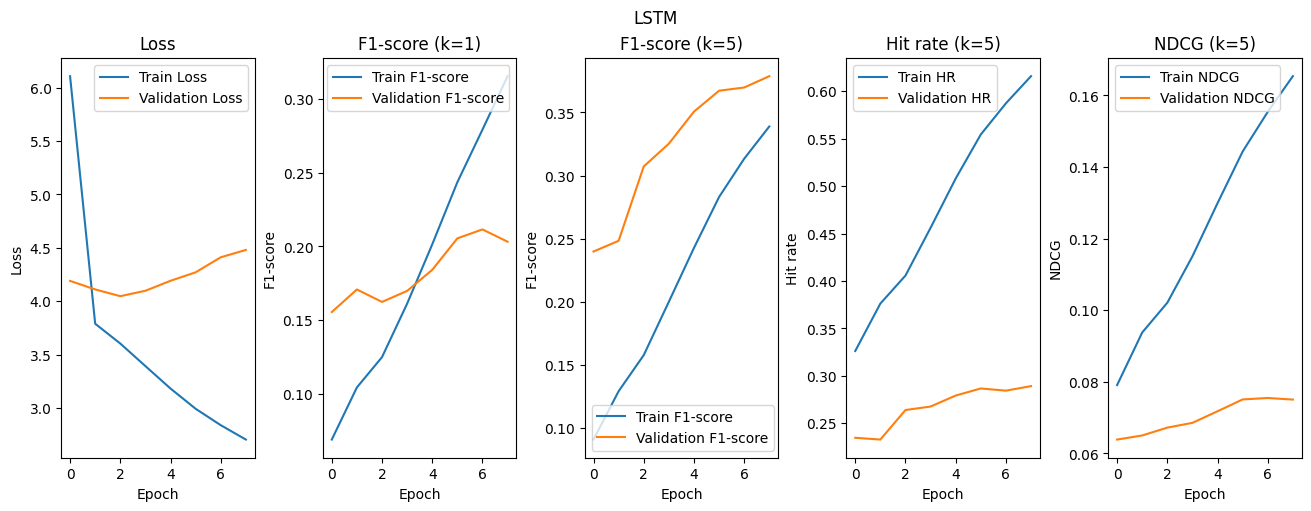

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1509 - f1_score: 0.2011 - f1_score_at_k: 0.3827 - hit_rate_at_k: 0.2895 - loss: 4.4405 - ndcg_at_k: 0.0743
Test loss: 4.4951
Test accuracy: 0.1486
Test F1@1: 0.1995
Test F1@5: 0.3801
Test HR@5: 0.2875
Test NDCG@5: 0.0734


In [32]:
parameters

{'user': 'users-5',
 'user_id': 'A100WO06OQR8BQ',
 'number_of_sequences_and_targets_before_removal': 48105,
 'number_of_sequences_and_targets_after_removal': 47373,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 40346,
 'num_unique_product_ids_in_targets': 173,
 'num_unique_product_ids_in_sequences': 20614,
 'number_of_sequences_and_targets_train': 32263,
 'number_of_sequences_and_targets_validation': 4045,
 'number_of_sequences_and_targets_test': 4038,
 'number_of_unique_products_in_targets_train': 169,
 'number_of_unique_products_in_targets_validation': 170,
 'number_of_unique_products_in_targets_test': 173,
 'model_lstm_test_loss': 4.495145320892334,
 'model_lstm_test_accuracy': 0.1486,
 'model_lstm_test_f1_score_k_1': 0.1995,
 'model_lstm_test_f1_score_k_5': 0.3801,
 'model_lstm_test_hr': 0.2875,
 'model_lstm_test_ndcg': 0.0734}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.1894 - f1_score: 0.1045 - f1_score_at_k: 0.1423 - hit_rate_at_k: 0.4544 - loss: 6.6427 - ndcg_at_k: 0.1101 - val_accuracy: 0.1006 - val_f1_score: 0.1248 - val_f1_score_at_k: 0.2406 - val_hit_rate_at_k: 0.2397 - val_loss: 4.2073 - val_ndcg_at_k: 0.0589
Epoch 2/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.2230 - f1_score: 0.1452 - f1_score_at_k: 0.1874 - hit_rate_at_k: 0.4692 - loss: 3.3856 - ndcg_at_k: 0.1189 - val_accuracy: 0.1523 - val_f1_score: 0.1731 - val_f1_score_at_k: 0.2602 - val_hit_rate_at_k: 0.2447 - val_loss: 4.0882 - val_ndcg_at_k: 0.0678
Epoch 3/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2460 - f1_score: 0.1726 - f1_score_at_k: 0.2139 - hit_rate_at_k: 0.5023 - loss: 3.2436 - ndcg_at_k: 0.1279 - val_accuracy: 0.1389 - val_f1_score: 0.1711 - val_f1_score_at_k: 0.3253 - val_hit_rate_at_k: 0.2759 - val_loss: 4.0426 - val_ndcg_at_k: 0.0709
Epoch 4/50
1009/1009 ━━━━━━━━━━━━━━━━

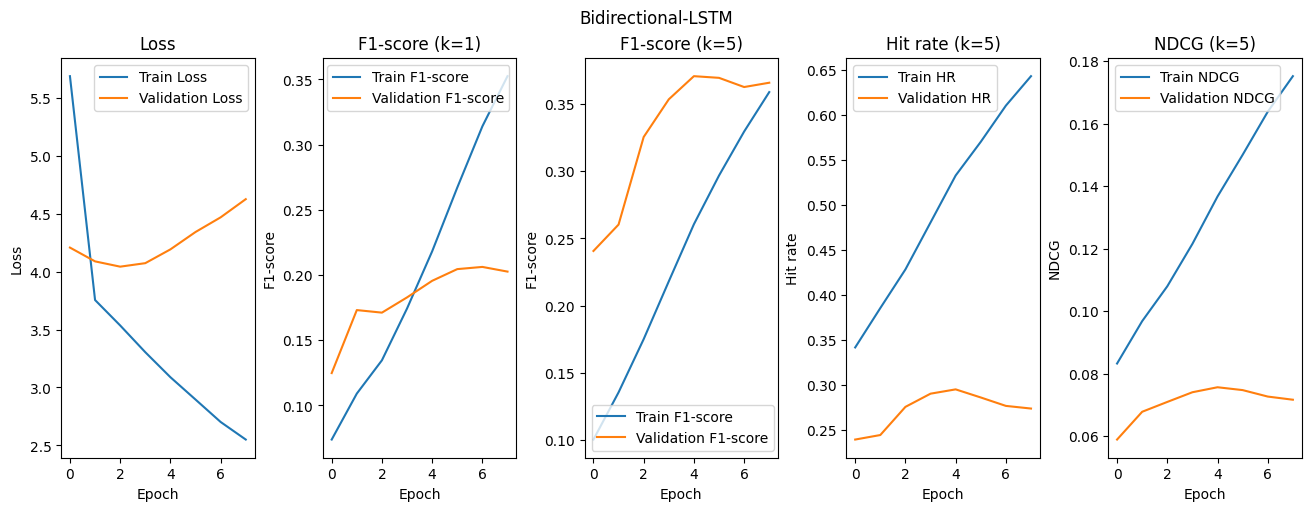

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1450 - f1_score: 0.1969 - f1_score_at_k: 0.3621 - hit_rate_at_k: 0.2713 - loss: 4.6173 - ndcg_at_k: 0.0699
Test loss: 4.6519
Test accuracy: 0.1488
Test F1@1: 0.2028
Test F1@5: 0.3776
Test HR@5: 0.2838
Test NDCG@5: 0.0728


In [37]:
parameters

{'user': 'users-5',
 'user_id': 'A100WO06OQR8BQ',
 'number_of_sequences_and_targets_before_removal': 48105,
 'number_of_sequences_and_targets_after_removal': 47373,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 40346,
 'num_unique_product_ids_in_targets': 173,
 'num_unique_product_ids_in_sequences': 20614,
 'number_of_sequences_and_targets_train': 32263,
 'number_of_sequences_and_targets_validation': 4045,
 'number_of_sequences_and_targets_test': 4038,
 'number_of_unique_products_in_targets_train': 169,
 'number_of_unique_products_in_targets_validation': 170,
 'number_of_unique_products_in_targets_test': 173,
 'model_lstm_test_loss': 4.495145320892334,
 'model_lstm_test_accuracy': 0.1486,
 'model_lstm_test_f1_score_k_1': 0.1995,
 'model_lstm_test_f1_score_k_5': 0.3801,
 'model_lstm_test_hr': 0.2875,
 'model_lstm_test_ndcg': 0.0734,
 'model_bi_lstm_test_loss': 4.651916027069092,
 'model_bi_lstm_test_accuracy': 0.1488,
 'model_bi_lstm_test_f1_score_k_1': 0.

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.1365 - f1_score: 0.0629 - f1_score_at_k: 0.1177 - hit_rate_at_k: 0.4309 - loss: 7.2621 - ndcg_at_k: 0.0968 - val_accuracy: 0.1132 - val_f1_score: 0.1398 - val_f1_score_at_k: 0.2385 - val_hit_rate_at_k: 0.2375 - val_loss: 4.2163 - val_ndcg_at_k: 0.0607
Epoch 2/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2188 - f1_score: 0.1425 - f1_score_at_k: 0.1885 - hit_rate_at_k: 0.4646 - loss: 3.4217 - ndcg_at_k: 0.1172 - val_accuracy: 0.1471 - val_f1_score: 0.1712 - val_f1_score_at_k: 0.2646 - val_hit_rate_at_k: 0.2486 - val_loss: 4.1095 - val_ndcg_at_k: 0.0669
Epoch 3/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2321 - f1_score: 0.1583 - f1_score_at_k: 0.1997 - hit_rate_at_k: 0.4838 - loss: 3.3174 - ndcg_at_k: 0.1223 - val_accuracy: 0.1592 - val_f1_score: 0.1814 - val_f1_score_at_k: 0.2894 - val_hit_rate_at_k: 0.2583 - val_loss: 4.0705 - val_ndcg_at_k: 0.0702
Epoch 4/50
1009/1009 ━━━━━━━━━━━━━━━━━

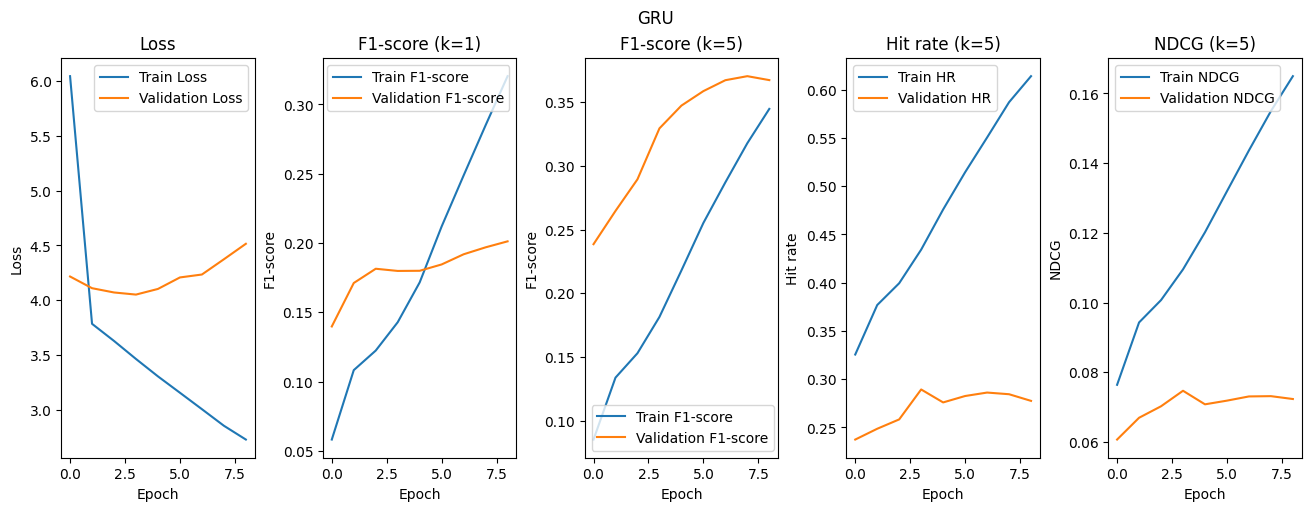

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1336 - f1_score: 0.1764 - f1_score_at_k: 0.3929 - hit_rate_at_k: 0.2933 - loss: 4.4553 - ndcg_at_k: 0.0722
Test loss: 4.4898
Test accuracy: 0.1414
Test F1@1: 0.191
Test F1@5: 0.3876
Test HR@5: 0.296
Test NDCG@5: 0.0742


In [42]:
parameters

{'user': 'users-5',
 'user_id': 'A100WO06OQR8BQ',
 'number_of_sequences_and_targets_before_removal': 48105,
 'number_of_sequences_and_targets_after_removal': 47373,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 40346,
 'num_unique_product_ids_in_targets': 173,
 'num_unique_product_ids_in_sequences': 20614,
 'number_of_sequences_and_targets_train': 32263,
 'number_of_sequences_and_targets_validation': 4045,
 'number_of_sequences_and_targets_test': 4038,
 'number_of_unique_products_in_targets_train': 169,
 'number_of_unique_products_in_targets_validation': 170,
 'number_of_unique_products_in_targets_test': 173,
 'model_lstm_test_loss': 4.495145320892334,
 'model_lstm_test_accuracy': 0.1486,
 'model_lstm_test_f1_score_k_1': 0.1995,
 'model_lstm_test_f1_score_k_5': 0.3801,
 'model_lstm_test_hr': 0.2875,
 'model_lstm_test_ndcg': 0.0734,
 'model_bi_lstm_test_loss': 4.651916027069092,
 'model_bi_lstm_test_accuracy': 0.1488,
 'model_bi_lstm_test_f1_score_k_1': 0.

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.1453 - f1_score: 0.0979 - f1_score_at_k: 0.1435 - hit_rate_at_k: 0.3305 - loss: 8.6153 - ndcg_at_k: 0.0810 - val_accuracy: 0.1033 - val_f1_score: 0.1221 - val_f1_score_at_k: 0.2522 - val_hit_rate_at_k: 0.2387 - val_loss: 4.2748 - val_ndcg_at_k: 0.0588
Epoch 2/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2003 - f1_score: 0.1265 - f1_score_at_k: 0.1810 - hit_rate_at_k: 0.4439 - loss: 3.5941 - ndcg_at_k: 0.1102 - val_accuracy: 0.1461 - val_f1_score: 0.1618 - val_f1_score_at_k: 0.2466 - val_hit_rate_at_k: 0.2392 - val_loss: 4.1525 - val_ndcg_at_k: 0.0655
Epoch 3/50
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2141 - f1_score: 0.1446 - f1_score_at_k: 0.1931 - hit_rate_at_k: 0.4605 - loss: 3.5071 - ndcg_at_k: 0.1157 - val_accuracy: 0.1268 - val_f1_score: 0.1537 - val_f1_score_at_k: 0.2432 - val_hit_rate_at_k: 0.2357 - val_loss: 4.1918 - val_ndcg_at_k: 0.0620
Epoch 4/50
1009/1009 ━━━━━━━━━━━━━━━━━

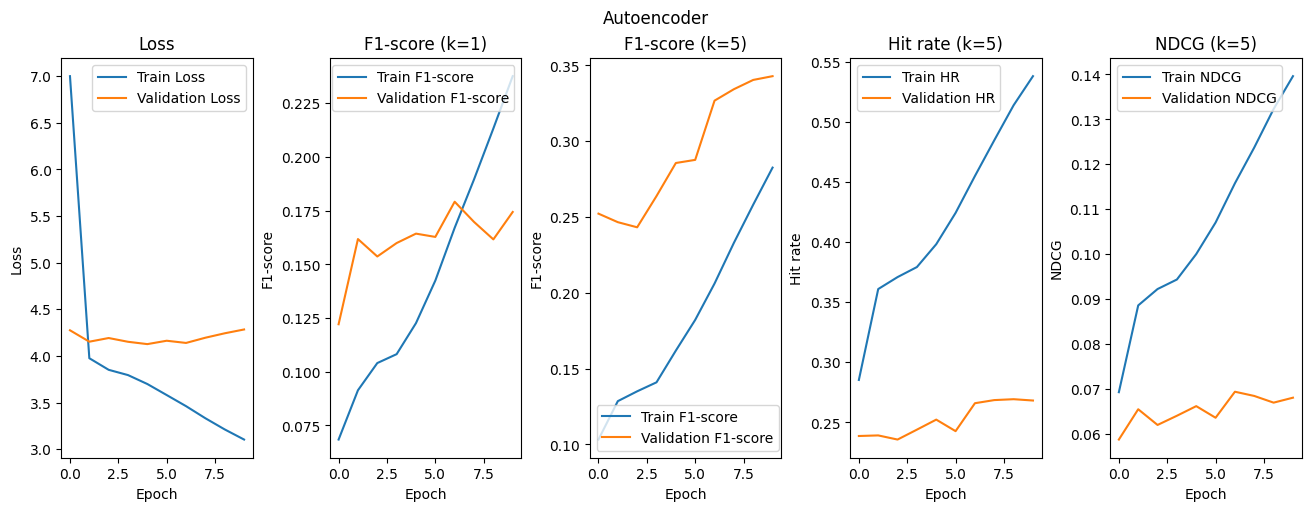

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1206 - f1_score: 0.1552 - f1_score_at_k: 0.2969 - hit_rate_at_k: 0.2312 - loss: 4.3517 - ndcg_at_k: 0.0594          
Test loss: 4.2778
Test accuracy: 0.1283
Test F1@1: 0.1679
Test F1@5: 0.3405
Test HR@5: 0.2648
Test NDCG@5: 0.0667


In [47]:
parameters

{'user': 'users-5',
 'user_id': 'A100WO06OQR8BQ',
 'number_of_sequences_and_targets_before_removal': 48105,
 'number_of_sequences_and_targets_after_removal': 47373,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 40346,
 'num_unique_product_ids_in_targets': 173,
 'num_unique_product_ids_in_sequences': 20614,
 'number_of_sequences_and_targets_train': 32263,
 'number_of_sequences_and_targets_validation': 4045,
 'number_of_sequences_and_targets_test': 4038,
 'number_of_unique_products_in_targets_train': 169,
 'number_of_unique_products_in_targets_validation': 170,
 'number_of_unique_products_in_targets_test': 173,
 'model_lstm_test_loss': 4.495145320892334,
 'model_lstm_test_accuracy': 0.1486,
 'model_lstm_test_f1_score_k_1': 0.1995,
 'model_lstm_test_f1_score_k_5': 0.3801,
 'model_lstm_test_hr': 0.2875,
 'model_lstm_test_ndcg': 0.0734,
 'model_bi_lstm_test_loss': 4.651916027069092,
 'model_bi_lstm_test_accuracy': 0.1488,
 'model_bi_lstm_test_f1_score_k_1': 0.

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A100WO06OQR8BQ', 'sequence': [90750, 92272], 'target': 79574}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 1.0
NDCG@10: 0.06362078338861465
-------------
HT@20: 1.0
NDCG@20: 0.04105878248810768
-------------
HT@50: 1.0
NDCG@50: 0.022412065416574478
-------------
HT@100: 1.0
NDCG@100: 0.013805308379232883
-------------
HT@200: 1.0
NDCG@200: 0.00830215122550726
-------------
HT@300: 1.0
NDCG@300: 0.0061011346988379955
-------------
HT@400: 1.0
NDCG@400: 0.0048818583600223064
-------------
HT@500: 1.0
NDCG@500: 0.004096909426152706
-------------
